In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import seaborn as sns
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib
from matplotlib.ticker import MaxNLocator
set1 = sns.color_palette('Set1')
sns.set_palette('Set1')

import requests
from bs4 import BeautifulSoup

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
headers = requests.utils.default_headers()
headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})
url = "https://www.worldometers.info/coronavirus/"
req = requests.get(url, headers)
soup = BeautifulSoup(req.content, 'html.parser')


t = soup.find(id="main_table_countries_today").text

a = np.array(t.strip().split("\n"))

b = a[153:]

columns = ['Country', 'TotalCases', 'NewCases', 'TotalDeaths',
       'NewDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical',
       'TotCases/1M pop', 'Deaths/1M pop', 'TotalTests', 'Tests/1M pop', '', '', 'Continent']
df = pd.DataFrame(np.split(b, range(15, len(b), 15)), columns=columns).iloc[:212]

def convert_float(field):
    field = field.replace(',', '')
    try:
        return float(field)
    except ValueError:
        return None

for c in ['TotCases/1M pop', 'Deaths/1M pop', 'Tests/1M pop']:
    df[c] = df[c].apply(convert_float)

for c in ['TotalCases', 'NewCases', 'TotalDeaths',
       'NewDeaths', 'TotalRecovered', 'ActiveCases', 'Serious,Critical',
       'TotalTests']:
    df[c] = df[c].apply(convert_float)
df.sort_values('TotalCases', ascending=False).head(20)

,Country,TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,ActiveCases,"Serious,Critical",TotCases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,,,Continent
157,Africa,4.574238e+12,NaN,NaN,122.0,NaN,2223.0,NaN,125.0,NaN,1909.0,NaN,189,2,"1,069"
138,Africa,3.430177e+12,NaN,NaN,107.0,NaN,3902.0,NaN,123.0,NaN,2913.0,NaN,866,,588
195,Africa,2.591151e+12,NaN,NaN,152.0,NaN,878.0,NaN,15.0,NaN,797.0,NaN,66,,"3,999"
119,Africa,2.573926e+11,NaN,NaN,92.0,NaN,7073.0,NaN,119.0,NaN,5750.0,NaN,"1,204",9,"11,282"
176,South America,2.637939e+10,NaN,NaN,137.0,NaN,1275.0,NaN,32.0,NaN,1070.0,NaN,173,,677
43,Asia,6.310403e+08,NaN,NaN,32.0,NaN,80054.0,495.0,576.0,NaN,55256.0,1829.0,"24,222",358,"8,704"
100,Europe,2.458538e+08,NaN,NaN,77.0,NaN,13014.0,NaN,435.0,NaN,7374.0,NaN,"5,205",47,"1,874"
62,North America,2.176861e+08,NaN,NaN,47.0,NaN,45244.0,NaN,930.0,NaN,32430.0,NaN,"11,884",7,219
15,"35,374",5.093626e+07,NaN,1.424266e+08,NaN,NaN,10.0,NaN,354530.0,NaN,28500.0,NaN,N/A,N/A,N/A
34,"114,339",3.777502e+07,NaN,3.194214e+07,NaN,NaN,25.0,NaN,112092.0,NaN,178.0,NaN,"108,831",,"3,083"


In [3]:
hun_list = []
page_i = 0
while True:
    try:
        t = pd.read_html(f"https://koronavirus.gov.hu/elhunytak/?page={page_i}")[0]
        page_i += 1
        hun_list.append(t)
    except ValueError:
        break
hun = pd.concat(hun_list)
hun = hun.rename(columns={
   'Sorszám': 'id',
    'Nem': 'gender',
    'Kor': 'age',
    'Alapbetegségek': 'conditions'
})
hun = hun.drop('id', axis=1)

# Általános statisztikák

In [4]:
print("Összes elhunyt:", len(hun))
print("Átlagéletkor:", hun.age.mean().round(1))
print("Medián életkor:", hun.age.median())
print("Életkor szórása:", hun.age.std().round(1))
gc = hun.gender.value_counts()
print("Férfi: {}, Nő: {}".format(gc.loc['Férfi'], gc.loc['Nő']))

Összes elhunyt: 600
Átlagéletkor: 77.5
Medián életkor: 79.0
Életkor szórása: 11.4
Férfi: 295, Nő: 305


In [5]:
daily_stats = pd.read_table("daily_stats.tsv", index_col="day", parse_dates=['day'])
today = pd.Timestamp.today()
if today.date() not in daily_stats.index:
    print("Adding today's stats")
    daily_stats.loc[today, "cnt"] = len(hun)
    daily_stats.loc[today, 'M'] = gc.loc['Férfi']# - daily_stats.loc[(datetime.now() - timedelta(1)).date(), 'M']
    daily_stats.loc[today, 'F'] = gc.loc['Nő']# - daily_stats.loc[(datetime.now() - timedelta(1)).date(), 'F']
    daily_stats.index = daily_stats.index.map(lambda i: i.date())
    
    headers = requests.utils.default_headers()
    headers.update({ 'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'})
    url = "https://koronavirus.gov.hu/"
    req = requests.get(url, headers)
    soup = BeautifulSoup(req.content, 'html.parser')
    for d in soup.find_all("div", class_="diagram-a"):
        label = d.find("span", class_="label").get_text()
        number = d.find("span", class_="number")
        if number:
            number = number.get_text().replace(" ", "")
            daily_stats.loc[today.date(), label] = int(number)
    daily_stats.to_csv("daily_stats.tsv", sep="\t")
daily_stats = daily_stats.rename(columns={'Fertőzött': 'case', 'Gyógyult': 'recovered'})

Adding today's stats


In [6]:
lineplot_kws = dict(marker='X', linewidth=3, markersize=10)

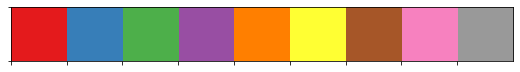

In [7]:
sns.palplot(sns.color_palette('Set1'))

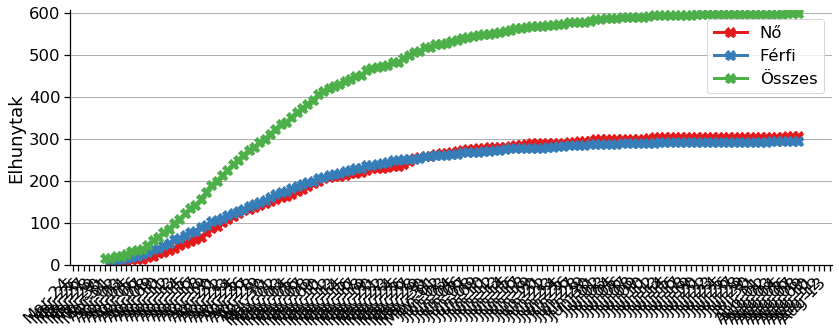

In [8]:
d = daily_stats.copy()
d = d.rename(columns={'M': 'Férfi', 'F': 'Nő', 'cnt': 'Összes'})
m = sns.color_palette('Set1')
cmap = [m[0], m[1], m[2]]
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(y=['Nő', 'Férfi', 'Összes'], color=cmap, ax=ax, **lineplot_kws)
    ax.set_ylim(0, len(hun)+5)
    ax.grid(axis='y')
    ax.set_xlabel("")
    ax.set_ylabel("Elhunytak")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/line_death_count.png", dpi=200)

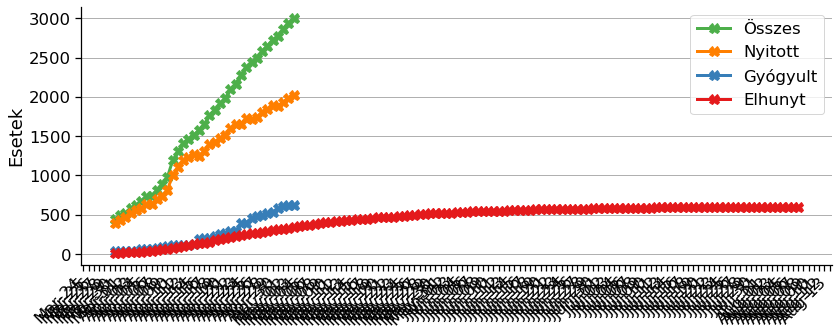

In [9]:
d = daily_stats.copy()
d = d.rename(columns={'recovered': 'Gyógyult', 'case': 'Összes', 'cnt': 'Elhunyt'})
d['Nyitott'] = d['Összes'] - d['Gyógyult'] - d['Elhunyt']
m = sns.color_palette('Set1')
cmap = [m[2], m[4], m[1], m[0]]
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(y=['Összes', 'Nyitott', 'Gyógyult', 'Elhunyt'], color=cmap, ax=ax, **lineplot_kws)
    ax.grid(axis='y')
    ax.set_xlabel("")
    ax.set_ylabel("Esetek")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/line_all.png", dpi=200)

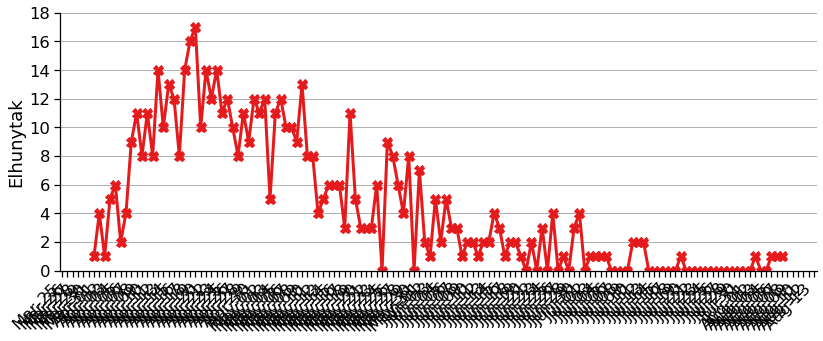

In [10]:
d = daily_stats.cnt.diff().dropna()
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_new_deaths.png", dpi=200)

# Meggyógyult / elhunyt naponta

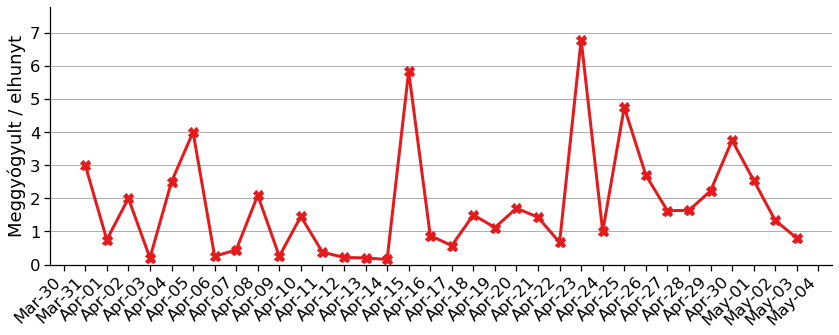

In [11]:
d = daily_stats[['cnt', 'recovered']].diff()
d['recovery/death'] = d['recovered'] / d['cnt']
d = d['recovery/death']

with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Meggyógyult / elhunyt")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_recovered_per_death.png", dpi=200)

In [12]:
daily_stats

,cnt,M,F,case,recovered,Hatósági házi karanténban,Mintavétel
day,,,,,,,
2020-03-30,15.0,NaN,NaN,447.0,34.0,NaN,NaN
2020-03-31,16.0,10.0,6.0,492.0,37.0,NaN,NaN
2020-04-01,20.0,12.0,8.0,525.0,40.0,NaN,NaN
2020-04-02,21.0,13.0,8.0,585.0,42.0,NaN,NaN
2020-04-03,26.0,16.0,11.0,623.0,43.0,NaN,NaN
...,...,...,...,...,...,...,...
2020-08-03,597.0,293.0,304.0,NaN,NaN,NaN,NaN
2020-08-04,597.0,293.0,304.0,NaN,NaN,NaN,NaN
2020-08-05,598.0,293.0,305.0,NaN,NaN,NaN,NaN


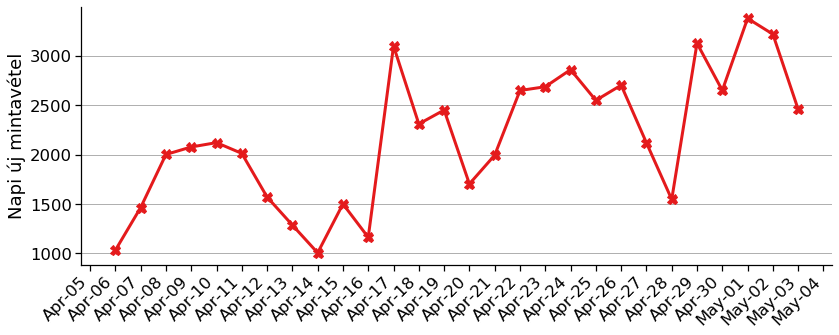

In [13]:
d = daily_stats['Mintavétel'].diff().dropna()
with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.plot(ax=ax, **lineplot_kws)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Napi új mintavétel")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_tests_per_day.png", dpi=200)

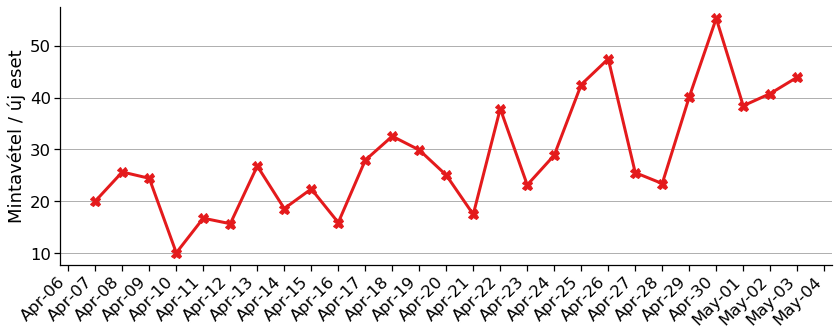

In [14]:
d = daily_stats[['case', 'Mintavétel']].diff()
d['Mintavétel/új eset'] = d['Mintavétel'] / d['case']
d = d['Mintavétel/új eset']

with sns.plotting_context('notebook', font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 5))
    d.dropna().iloc[1:].plot(ax=ax, **lineplot_kws)
    #ax.set_ylim(0, d.max()+1)
    sns.despine()
    ax.grid(axis='y')
    ax.set_ylabel("Mintavétel / új eset")
    ax.set_xlabel("")
    plt.xticks(rotation=45, ha='right')
    ax.xaxis.set_major_locator(matplotlib.dates.DayLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b-%d"))
    plt.tight_layout()
    fig.savefig("fig/line_test_per_case.png", dpi=200)

# Korosztályonként

In [15]:
labels = ['40 alatt', '40-49', '50-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-90', '90 felett']
hun['age_group'] = pd.cut(hun.age, bins=[0, 39, 49, 59, 64, 69, 74, 79, 84, 89, 120], labels=labels)

In [16]:
barplot_kws = dict(alpha=0.8, color=sns.color_palette('Set1')[2], zorder=3)

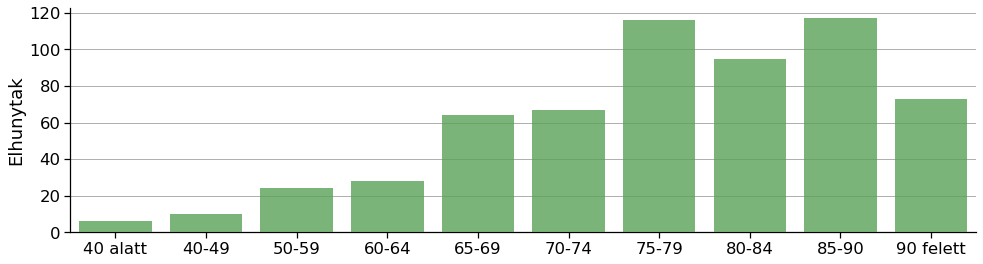

In [17]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(14, 4))
    sns.countplot(hun.age_group, ax=ax, **barplot_kws)
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    ax.grid(axis='y')
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_death_by_age_group.png", dpi=200)

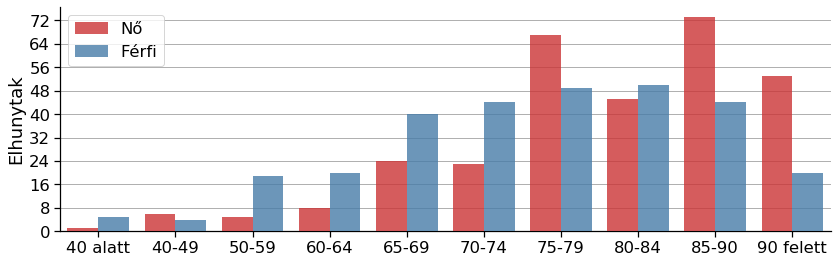

In [18]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 4))
    h = hun.groupby(['gender', 'age_group']).size().reset_index()
    h = h.rename(columns={0: 'cnt'})
    sns.barplot(x=h.age_group, y=h.cnt, hue=h.gender, ax=ax, hue_order=['Nő', 'Férfi'],
                palette=[set1[0], set1[1]], **barplot_kws)
    ax.legend(title="", loc='upper left', fancybox=True)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(axis='y')
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("")
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_death_by_age_group_and_gender.png", dpi=200)

# Alapbetegségek

In [19]:
name_mapping = {}
with open("name_mapping.tsv") as f:
    for line in f:
        fd = line.strip().split("\t")
        name_mapping[fd[0]] = fd[1]

list_of_conditions = []
norm_map = {
    "anyagcsere és daganatos betegség": "anyagcsere betegség, daganatos betegség",
    "szív- és veseelégtelenség": "szívelégtelenség, veseelégtelenség",
}

def split_conditions(conditions):
    conditions = conditions.strip()
    cnt = 0
    if conditions in ("adat feltöltés alatt", "adatok feltöltése folyamatban", "adat feltöltése folyamatban", "nincs adat", "adatok feltöltés alatt"):
        return None
    conditions = conditions.replace("\xa0", " ")
    for src, tgt in norm_map.items():
        conditions = conditions.replace(src, tgt)
    for c in conditions.split(","):
        c = c.strip()
        if not c:
            continue
        c = name_mapping.get(c, c)
        list_of_conditions.append(c)
        cnt += 1
    return cnt
        
hun['condition_count'] = hun.conditions.apply(split_conditions)

lc = Counter(list_of_conditions)
conditions = pd.Series(lc)
conditions = conditions.reset_index().rename(columns={'index': 'condition', 0: 'cnt'})

categories = pd.read_table("categories.tsv", names=['condition', 'category'], skiprows=1)
all_cond = set(categories.condition.values)
for c in categories.category.unique():
    if c not in all_cond:
        categories = categories.append(pd.Series({'condition': c, 'category': c}), ignore_index=True)

conditions = conditions.merge(categories, on='condition', how='left')

# Alapbetegségek száma

Hány olyan elhunyt van, akinek 0, 1 vagy több alapbetegsége van.

In [20]:
cond_cnt = hun.condition_count.value_counts(dropna=False).sort_index()
cond_cnt['NA'] = cond_cnt.loc[np.nan]

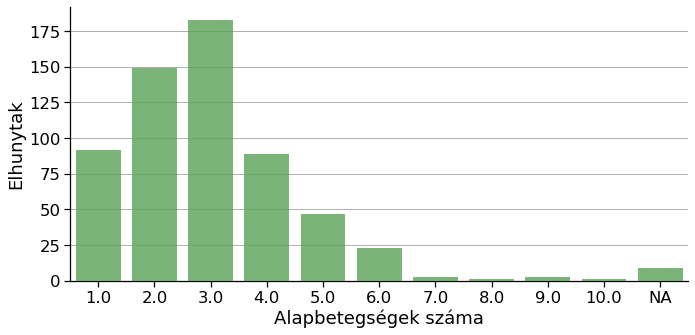

In [21]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(10, 5))
    #sns.countplot(hun.condition_count, ax=ax, **barplot_kws)
    sns.barplot(x=cond_cnt.index, y=cond_cnt, ax=ax, **barplot_kws)
    ax.set_ylabel("Elhunytak")
    ax.set_xlabel("Alapbetegségek száma")
    sns.despine()
    ax.grid(axis='y', zorder=0)
    plt.tight_layout()
    fig.savefig("fig/condition_histogram.png", dpi=200)

# 10 leggyakoribb betegség

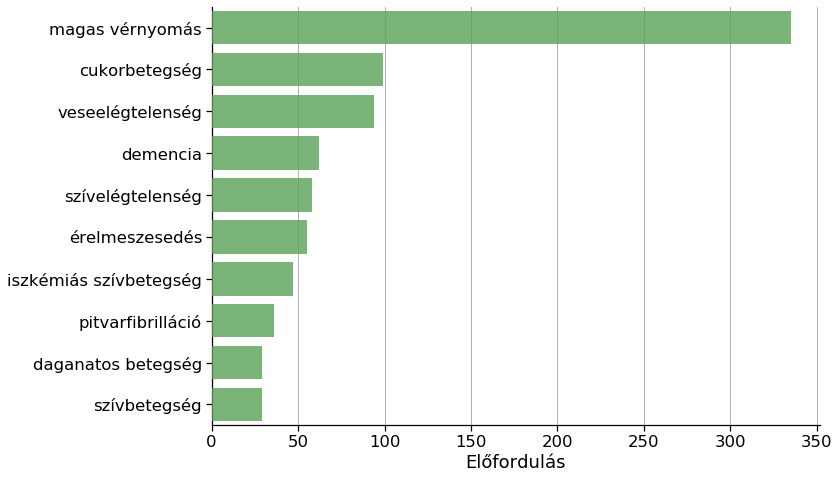

In [22]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 7))
    common = conditions.sort_values('cnt', ascending=False).head(10)
    sns.barplot(y=common.condition, x=common.cnt, ax=ax, **barplot_kws)
    ax.set_ylabel("")
    ax.set_xlabel("Előfordulás")
    ax.grid(axis='x')
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_most_common_diseases.png", dpi=200)

# Kategóriák

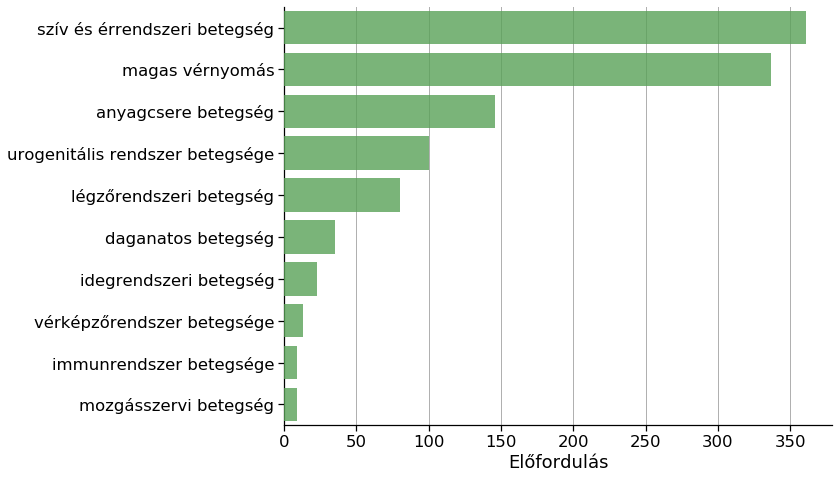

In [23]:
with sns.plotting_context("notebook", font_scale=1.5):
    fig, ax = plt.subplots(1, figsize=(12, 7))
    common = conditions.groupby('category')['cnt'].sum().sort_values(ascending=False).head(10)
    sns.barplot(y=common.index, x=common, ax=ax, **barplot_kws)
    ax.set_ylabel("")
    ax.grid(axis='x')
    ax.set_xlabel("Előfordulás")
    sns.despine()
    plt.tight_layout()
    fig.savefig("fig/bar_icd.png", dpi=200)

In [24]:
print("\n".join(conditions[conditions.category.isnull()].condition))

COPD (krónikus obstruktív tüdőbetegség)
pangásos szívelégtelenség
demencia
pajzsmirigy-alulműködés
kiszáradás
tüdő rosszindulatú daganata
tüdőtágulat
cachexia
carcinoma neuroendocrinicum
agyvérzés
jobb láb égési sérülése utáni szeptikus állapot
cirrhosis hepatis
hepatitis
haemodialysis
AMI
hepatitis C
inop.májkapu tumor
decubitus
EBSL termelő E.coli fertőzés
miokardinális infarktus
vesebetegség
krónikus uraemia
elhízás
koszorúér keringési zavar
vastagbélrák
szívbillentyű hibák
depresszió
hasnyálmirigy-daganat
gyomorműtét
csípőprotézis műtét
agyi érszűkület
táplálkozási negativizmus
véralkotósejt betegség
aorta műbillentyű
heresérv
anaemia
obesitas
endometrium adenocarcinoma
toxikus májbetegség májzsugorral
májkóma
magas vérnyomás cukorbetegség
daganatos betegségek
vérképző rendszeri zavarok
inzulinos cukorbetegség
alkoholizmus
béldaganat
nyombélfekély
magas-vérnyomás
emlőrák
pitvari fibrilláció
anémia
gyomorfekély heveny vérzéssel
bélelzáródás és légzési elégtelenség
pitvar fibrilláció